# Luminosity

In [1]:
from unicodedata import lookup

from spice.models import IcosphereModel
from spice.spectrum import simulate_spectrum
from spice.spectrum.spectrum import simulate_total_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
from synphot import SourceSpectrum
from synphot.models import BlackBody1D
from synphot import SpectralElement
%matplotlib inline
from astropy import constants as const

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


Let's use a simple, blackbody model just for the testing purposes, alogside with a solar-like model.

In [2]:
bb = Blackbody()
model = IcosphereModel.construct(10000, u.solRad.to(u.cm), u.solMass.to(u.kg), bb.solar_parameters, bb.parameter_names)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:211: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


The model surface area matches the solar surface area calculated from the radius.

In [43]:
u.solRad.to(u.cm)**2*4*np.pi-np.sum(model.areas)

Array(0., dtype=float64)

To test the bolometric luminosity value, let's choose a wide range of wavelengths.

In [44]:
vws = jnp.linspace(1., 100000., 20000)

Text(0, 0.5, 'Intensity [erg/s/cm$^3$]')

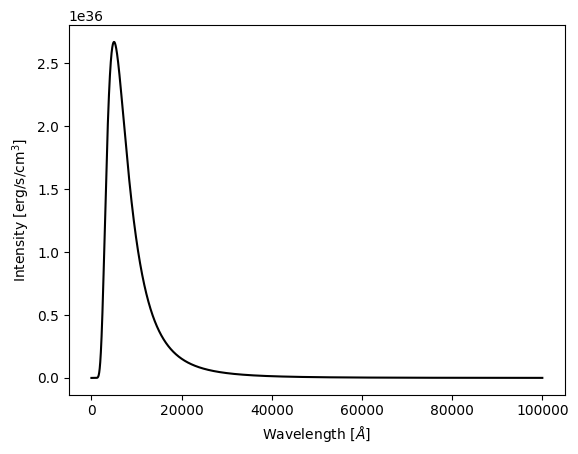

In [45]:
i_bb = simulate_spectrum(bb.intensity, model, jnp.log10(vws), chunk_size=1000)
plt.plot(vws, i_bb[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Intensity [erg/s/cm$^3$]')

Now let's calculate the flux.

Text(0, 0.5, 'Flux')

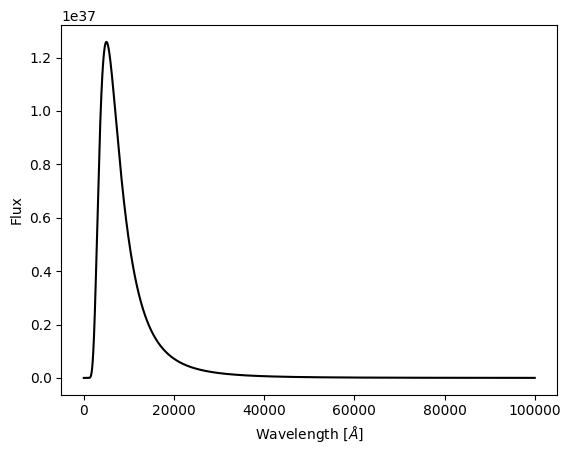

In [46]:
f_bb = simulate_total_flux(bb.flux, model, jnp.log10(vws), chunk_size=1000)
plt.plot(vws, f_bb[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Flux')

# Comparison with Synphot

In [47]:
from synphot.models import Empirical1D
from synphot import SourceSpectrum, units

bb_synphot = SourceSpectrum(Empirical1D, points=vws, lookup_table=i_bb[:, 0]/1e8*units.FLAM)

FLAM is erg/s/cm^2/Angstrom per Steradian. I have converted it from our format of erg/s/cm^3 to erg/s/cm^2/Angstrom.

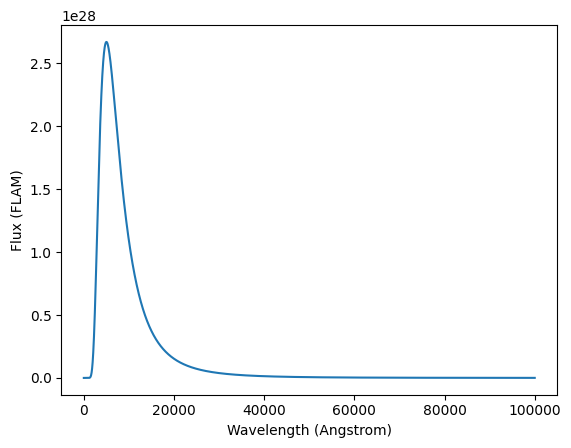

In [48]:
bb_synphot.plot(flux_unit=units.FLAM)

In [49]:
from synphot import Observation
i = SpectralElement.from_filter('cousins_i') 
obs = Observation(bb_synphot/((10*u.pc.to(u.cm))**2), i, binset=vws)
obs.effstim(u.ABmag, wavelengths=vws)

<Magnitude 4.94750223 mag(AB)>

The Sun has a luminosity of 4.51 in this filter

# Filters

Let's use the ```Filter``` subclasses to check the passband luminosities.

In [50]:
from spice.spectrum.filter import *

In [51]:
bessel_b = BesselB()
bessel_i = BesselI()
gaia_g = GaiaG()
johnson_v = JohnsonV()

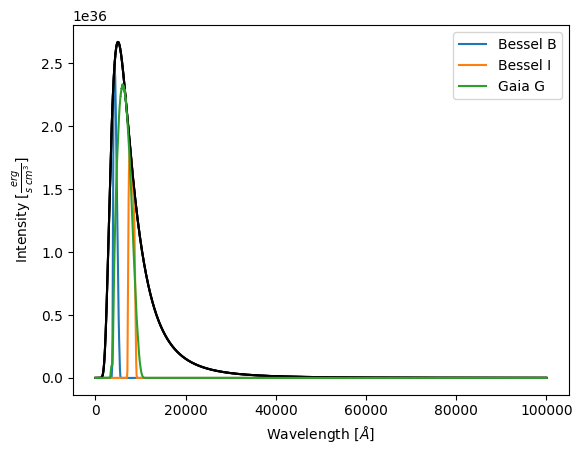

In [52]:
bessel_b.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
bessel_i.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
gaia_g.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])

The passband luminosities can be calculated using the ```AB_passband_luminosity``` function. Make sure to divide the observed luminosity by the distance first!

In [53]:
from spice.spectrum.spectrum import AB_passband_luminosity
from jax.typing import ArrayLike
from jax.scipy.integrate import trapezoid
from typing import Callable, List
from spice.models import MeshModel
import math
from functools import partial
from spice.spectrum.utils import ERG_S_TO_W, intensity_wavelengths_to_hz, H_CONST_ERG_S, JY_TO_ERG
from spice.spectrum.filter import Filter

C: float = 299792.458  # km/s

In [54]:
def AB_passband_luminosity_new(filter: Filter,
                           wavelengths: ArrayLike,
                           intensity: ArrayLike,
                           distance: float = 3.085677581491367e+19) -> ArrayLike:
    """Return the passband luminosity in a given filter.

    Args:
        filter (Filter):
        wavelengths (ArrayLike): wavelengths [Angstrom]
        intensity (ArrayLike): intensity [erg/s/cm^3]
        distance (float, optional): distance in cm. Defaults to 3.08e+19 (10 parsecs in cm)

    Returns:
        ArrayLike: passband luminosity [mag]
    """
    # vws_hz, intensity_hz = intensity_wavelengths_to_hz(wavelengths, intensity)
    # transmission_responses = filter.filter_responses_for_frequencies(vws_hz)
    transmission_responses = filter.filter_responses_for_wavelengths(wavelengths)
    intensity /= (jnp.power(distance, 2))
    return -2.5 * jnp.log10(
        trapezoid(x=wavelengths*1e-8, y=wavelengths * 1e-8 * intensity * transmission_responses) /
        (3.631*1e-20*C*1e5*trapezoid(x=wavelengths*1e-8, y=transmission_responses/(wavelengths*1e-8)))
    )

def ST_passband_luminosity(filter: Filter,
                           wavelengths: ArrayLike,
                           intensity: ArrayLike,
                           distance: float = 3.085677581491367e+19) -> ArrayLike:
    """Return the passband luminosity in a given filter.

    Args:
        filter (Filter):
        wavelengths (ArrayLike): wavelengths [Angstrom]
        intensity (ArrayLike): intensity [erg/s/cm^3]
        distance (float, optional): distance in cm. Defaults to 3.08e+19 (10 parsecs in cm)

    Returns:
        ArrayLike: passband luminosity [mag]
    """
    transmission_responses = filter.filter_responses_for_wavelengths(wavelengths)
    intensity /= (jnp.power(distance, 2))
    return -2.5 * jnp.log10(
        trapezoid(x=wavelengths, y=wavelengths*intensity/1e8*transmission_responses) /
        trapezoid(x=wavelengths, y=wavelengths*transmission_responses)
    )-21.10

def AB_passband_luminosity_hz(filter: Filter,
                           wavelengths: ArrayLike,
                           intensity: ArrayLike,
                           distance: float = 3.085677581491367e+19) -> ArrayLike:
    """Return the passband luminosity in a given filter.

    Args:
        filter (Filter):
        wavelengths (ArrayLike): wavelengths [Angstrom]
        intensity (ArrayLike): intensity [erg/s/cm^3]
        distance (float, optional): distance in cm. Defaults to 3.08e+19 (5 parsecs in cm)

    Returns:
        ArrayLike: passband luminosity [mag]
    """
    vws_hz, intensity_hz = intensity_wavelengths_to_hz(wavelengths, intensity)
    intensity_hz /= (jnp.power(distance, 2))
    transmission_responses = filter.filter_responses_for_frequencies(vws_hz)
    return -2.5 * jnp.log10(
        trapezoid(x=vws_hz, y=intensity_hz * JY_TO_ERG * transmission_responses / vws_hz) /
        trapezoid(x=vws_hz, y=transmission_responses / vws_hz)
    )-48.60

In [55]:
AB_passband_luminosity_hz(johnson_v, vws, 0.5*np.pi*i_bb[:, 0])

Array(4.80554859, dtype=float64)

It should be 4.80

Comparison between the theoretical flux and the calculated flux - the calculated flux is incorrect...

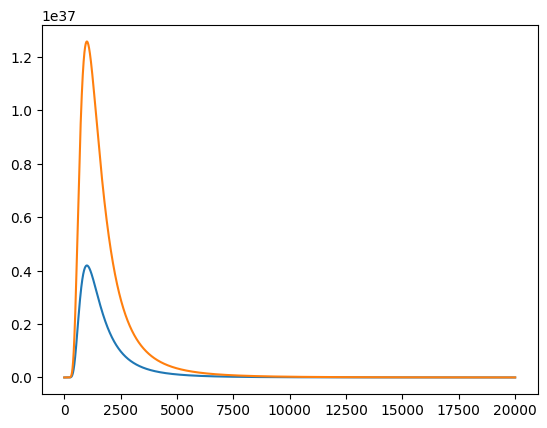

In [57]:
plt.plot(0.5*np.pi*i_bb[:, 0])
plt.plot(f_bb[:, 0])

In [58]:
solar_apparent_mag_B = ST_passband_luminosity(bessel_b, vws, 0.5*np.pi*i_bb[:, 0])
solar_apparent_mag_I = ST_passband_luminosity(bessel_i, vws, 0.5*np.pi*i_bb[:, 0])
solar_apparent_mag_G = ST_passband_luminosity(gaia_g, vws, 0.5*np.pi*i_bb[:, 0])
solar_johnson_v = ST_passband_luminosity(johnson_v, vws, 0.5*np.pi*i_bb[:, 0])

print("Apparent magnitude of the Sun")
print("Bessel B:\t", solar_apparent_mag_B, "mag")
print("Bessel I:\t", solar_apparent_mag_I, "mag")
print("Gaia G:\t\t", solar_apparent_mag_G, "mag")

print("Johnson V:\t\t", solar_johnson_v, "mag")

Apparent magnitude of the Sun
Bessel B:	 4.851020334894095 mag
Bessel I:	 5.288306321201571 mag
Gaia G:		 5.081519235941521 mag
Johnson V:		 4.825972001097242 mag


In [59]:
AB_passband_luminosity(JohnsonU(), vws, 0.5*np.pi*i_bb[:, 0])

Array(6.11519807, dtype=float64)

# Bolometric luminosity of the Sun

The bolometric luminosity of the Sun is the energy that is outputted by the whole Sun. To calculate that, we need to obtain the total flux first.

In [60]:
from spice.spectrum import luminosity, absolute_bol_luminosity

In [61]:
solar_luminosity = luminosity(bb.flux, model, vws)
print("Sun's bolometric luminosity:", solar_luminosity, "erg/s")
print("Sun's absolute bolometric luminosity:", absolute_bol_luminosity(solar_luminosity), "mag")

Sun's bolometric luminosity: 9.593197785450667e+32 erg/s
Sun's absolute bolometric luminosity: 6.242491503688955 mag


Let's compare that to the theoretical luminosity:

$L=4\pi R^2 \sigma T^4$

In [62]:
sigma = (5.67*1e-8*u.W/(u.m**2)/(u.K**4)).to(u.erg/(u.cm**2)/(u.s)/(u.K**4))
print("Theoretical luminosity of the Sun:", 4*np.pi*(u.solRad.to(u.cm)**2)*sigma*(5777*u.K)**4, "erg/s")

Theoretical luminosity of the Sun: 3.8410185077511094e+33 erg / (s cm2) erg/s


In [63]:
3.8410185077511094e+33-3.838501261033883e+33

2.517246717226292e+30

In [64]:
u.solLum.to(u.erg/u.s)

3.8279999999999997e+33